In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, get_data, binarize, normal_kl
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring, RoughWell, TiltedGaussian
from utils.layers import Linear, Parallel, Sequential, Zip, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.losses import get_loss, loss_mixed

In [32]:
tf.reset_default_graph()

In [ ]:
gaussian = RoughWell(dim=2, easy=False, eps=0.05)

In [3]:
size1 = 200
size2 = 200

x_dim = 100

# gaussian = Gaussian(np.zeros(2,), np.array([[10., 0.], [0., 0.1]]))
# gaussian = gen_ring(r=2.0, var=.1, nb_mixtures=4)
# gaussian = RoughWell(dim=2, eps=0.1, easy=False)
gaussian = TiltedGaussian(100, -3, 3)

sigma1 = 50.
sigma2 = 2

def energy(x):
    n = tf.reduce_sum(tf.square(x), 1) / (2 * sigma1 ** 2)
    return n + tf.reduce_sum(tf.cos(x * np.pi / sigma2), 1)

def net_factory(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, size1, scope='embed_1', factor=0.33),
                Linear(x_dim, size1, scope='embed_2', factor=factor * 0.33),
                Linear(2, size1, scope='embed_3', factor=0.33),
                lambda _, *args, **kwargs: 0.
            ]),
            sum,
            tf.nn.softplus,
            Linear(size1, size2, scope='linear_1'),
            tf.nn.softplus,
            Parallel([
                Sequential([
                    Linear(size1, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(size1, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(size1, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])
        ])
    return net

dynamics = Dynamics(
    x_dim, 
    gaussian.get_energy_function(), 
    T=10, 
    eps=0.01, 
    hmc=False, 
    eps_trainable=True, 
    net_factory=net_factory, 
    use_temperature=False
)

17395.3188028 float64


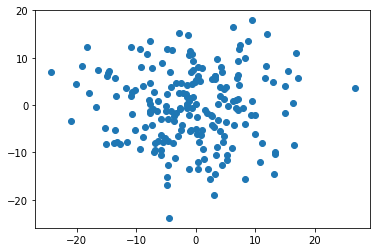

In [8]:
S = gaussian.get_samples(2000)
plt.scatter(S[:, 0], S[:, 9])

In [10]:
C = np.cov(S.T)
np.linalg.eigvals(C)

array([  9.25483042e+02,   8.73872872e+02,   7.63702771e+02,
         7.08871144e+02,   6.44947195e+02,   5.82905837e+02,
         5.42751675e+02,   5.27910108e+02,   4.45104150e+02,
         4.04528857e+02,   3.96870380e+02,   3.78377436e+02,
         2.94451957e+02,   2.65856832e+02,   2.17876787e+02,
         2.04312039e+02,   1.62991147e+02,   1.18955396e+02,
         9.79772609e+01,   7.67471621e+01,   4.70326133e+01,
         4.27934324e+01,   3.80743767e+01,   3.40631720e+01,
         2.57866805e+01,   1.94189412e+01,   1.67197290e+01,
         1.55725543e+01,   1.30250235e+01,   1.22952997e+01,
         1.08152950e+01,   1.00611767e+01,   8.51122086e+00,
         7.45892640e+00,   6.83597478e+00,   6.12753542e+00,
         5.26876928e+00,   4.13440320e+00,   3.96803528e+00,
         3.20585876e+00,   3.02091318e+00,   2.84090151e+00,
         2.43928188e+00,   1.67454139e+00,   1.57720711e+00,
         1.40128469e+00,   1.15191004e+00,   1.02266249e+00,
         8.86575546e-01,

In [11]:
def mixed(x, Lx, px, scale=1.0):
    v = tf.reduce_sum(tf.square(x - Lx) / (scale ** 2), 1) * px + 1e-4
    # v = tf.boolean_mask(v, tf.is_finite(v))
    # return - tf.reduce_mean(v)
    return tf.reduce_mean(1.0 / v) - tf.reduce_mean(v)

In [12]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x), dtype=tf.float32)

Lx, _, px, MHx = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

energy = gaussian.get_energy_function()

energy_diff1 = tf.square(energy(x) - energy(Lx)) * px + 1e-4
energy_diff2 = tf.square(energy(z) - energy(Lz)) * pz + 1e-4

energy_loss = tf.reduce_mean(1.0 / energy_diff1) - tf.reduce_mean(energy_diff1) + tf.reduce_mean(1.0 / energy_diff2) - tf.reduce_mean(energy_diff2)
distance_loss = mixed(x, Lx, px) + mixed(z, Lz, pz)
loss = distance_loss + 0.00 * energy_loss

In [13]:
lr = tf.placeholder(tf.float32, shape=())
global_step = tf.Variable(0., trainable=False)
learning_rate = tf.train.exponential_decay(lr, global_step,
                                            750, 0.96, staircase=True)
#learning_rate = lr
opt_sampler = tf.train.AdamOptimizer(learning_rate=learning_rate)
gradients, variables = zip(*opt_sampler.compute_gradients(loss))
# gradients, global_norm = tf.clip_by_global_norm(gradients, 100.0)
train_op = opt_sampler.apply_gradients(zip(gradients, variables), global_step=global_step)

In [33]:
samples = np.random.randn(200, 100)
# L = []
# S = []
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

for t in range(5000):
#     print sess.run(dynamics.eps)
    S.append(np.copy(samples))
    samples, loss_, d_loss_, e_loss_, px_, lr_, _ = sess.run([MHx[0], loss, distance_loss, energy_loss, px, learning_rate, train_op], {x: samples, lr: 1e-4})
    L.append(loss_)
    
    if t % 100 == 0:
        print '%d/%d: Loss=%.2e, Distance Loss=%.2e, Energy Loss=%.2e, p_acc=%.2f, lr=%g' % (t, 10000, loss_, d_loss_, e_loss_, np.mean(px_), lr_)
        

0/10000: Loss=-8.61e+00, Distance Loss=-8.61e+00, Energy Loss=-8.47e+06, p_acc=1.00, lr=9.6e-05
100/10000: Loss=-2.67e+01, Distance Loss=-2.67e+01, Energy Loss=-4.14e+06, p_acc=0.70, lr=9.216e-05
200/10000: Loss=-2.61e+01, Distance Loss=-2.61e+01, Energy Loss=-4.25e+06, p_acc=0.70, lr=9.216e-05


KeyboardInterrupt: 

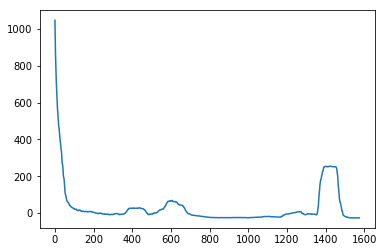

In [34]:
def smooth(x, k=25):
    n = len(x)
    return [np.mean(x[t: t+k]) for t in range(n - k)]
plt.plot(smooth(L, k=100))

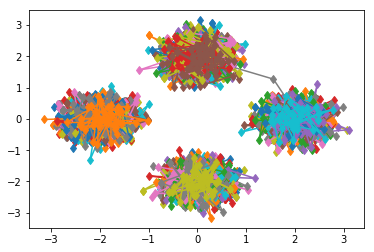

In [41]:
samples = gaussian.get_samples(200)
plt.scatter(samples[:, 0], samples[:, 1], color='grey')
S = np.array(S)
plt.plot(S[-50:, :, 0], S[-50:, :, 1], marker='d')

In [ ]:
e = energy(x)

e_ = sess.run(e, {x: S[:, 0, :]})

plt.plot(e_)

In [49]:
samples = np.random.randn(200, 100)
samples = final_samples[-1]

final_samples = []
for t in range(10000):
    final_samples.append(np.copy(samples))
    samples, px_ = sess.run([MHx[0], px], {x: samples})
    if t % 100 == 0: print px_.mean()

0.599917
0.601142
0.546163
0.550497
0.491904
0.523447
0.543043
0.556604
0.501536
0.511537
0.503207
0.455269
0.482599
0.464831
0.46311
0.456165
0.406268
0.491021
0.439759
0.443496
0.456302
0.423184
0.427377
0.457241
0.400544
0.405666
0.46808
0.360597
0.392067
0.379598
0.395313
0.382086
0.361989
0.386259
0.347034
0.407087
0.42733
0.373398
0.371155
0.38216
0.384624
0.346904
0.339378
0.397254
0.340536
0.362787
0.360557
0.287142
0.371069
0.334634
0.320817
0.347677
0.317991
0.291061
0.347297
0.321846
0.344756
0.304679
0.387651
0.337056
0.328373
0.317116
0.296915
0.29904
0.297667
0.357392
0.273893
0.345135
0.279879
0.309033
0.288651
0.301704
0.292479
0.300065
0.267962
0.317056
0.263203
0.326258
0.263378
0.266761
0.271421
0.280895
0.278754
0.28301
0.255217
0.273834
0.279372
0.295891
0.277016
0.267437
0.244588
0.238775
0.272914
0.269803
0.25063
0.25741
0.26955
0.24362
0.245166
0.257599


In [31]:
F.shape

(500, 200, 100)

In [ ]:
F = np.array(final_samples)
# plt.scatter(samples[:, 0], samples[:, 1], color='grey', alpha=0.2)
# plt.plot(F[:, 5:10, 0], F[:, 5:10, 1], marker='d')
# plt.show()

In [46]:
mu = F.mean(axis=0)

In [ ]:
autocov = np.array([autocovariance(F, tau=t) for t in range(9999)])

In [ ]:
plt.plot(autocov)

In [ ]:
F = np.array(final_samples[1000:])
mu = F.mean(axis=(0, 1))
I = np.array(H[:1000])
plt.plot([autocovariance(F - mu, tau=t) for t in range(199)], label='CS')
plt.plot([autocovariance(G - mu, tau=t) for t in range(199)], label='CS')
plt.plot([autocovariance(I - mu, tau=t) for t in range(199)], label='CS')
plt.xlim(0, 100)

In [ ]:
S = gaussian.get_samples(200)
plt.scatter(S[:, 0], S[:, 1])
plt.plot(G[:20, 1, 0], G[:20, 1, 1], color='red', marker='d', linewidth=1.2)

In [ ]:
plt.hist(F[:1000, 5, 0].flatten(), bins=20)

In [ ]:
H = get_hmc_samples(eps=0.2)

In [ ]:
G = np.array(H[1000:])

plt.hist(G[:500, 50, 0].flatten(), bins=20)

In [ ]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

In [ ]:
gaussian.easy = False

In [ ]:
energy

In [ ]:
S = gaussian.get_samples(200)

mu = np.mean(F, axis=(0, 1))
std = np.std(F, axis=(0, 1))
for eps in [0.2]:
    print eps
    H = get_hmc_samples(eps, samples=S, steps=5000)
    plt.plot(np.abs([autocovariance((H - mu) / std, tau=t) for t in range(4999)]), label='$\epsilon=%.3f$' % eps)
plt.plot(np.abs([autocovariance((np.array(final_samples) - mu) / std, tau=t) for t in range(4999)]), label='Cosa Nostra')
plt.xlabel('# gradient steps')
plt.ylabel('Autocovariance')
plt.legend()

In [ ]:
plt.acorr(F[:,0,0], maxlags=300,  normed=True, usevlines=False)
plt.xlim(0, 300)

In [ ]:
plt.plot(H[:100, 0, 0], H[:100, 0, 1], marker='d')

In [ ]:
gaussian.sigma = 3.

In [ ]:
mu = H1.mean(axis=(0, 1))
print mu

In [ ]:
S = gaussian.get_samples(n=5)
H = get_hmc_samples(0.3, samples=S, steps=400)
# for eps in np.arange(0.1, 0.7, 0.1):
#     H = get_hmc_samples(eps, samples=S)
#     plt.plot(np.abs([autocovariance(H-mu, tau=t) for t in range(199)]), label='$\epsilon=%.3f$' % eps)
# # plt.plot(np.abs([autocovariance(F-mu, tau=t) for t in range(199)]), label='Cosa Nostra')
# plt.xlabel('# gradient steps')
# plt.ylabel('Autocovariance')
# plt.legend()

In [ ]:
np.isnan(H.flatten()).sum()

In [ ]:
plt.plot(H[:, 2, 0])

In [ ]:
plt.plot(np.abs([autocovariance(H-mu, tau=t) for t in range(199)]), label='$\epsilon=%.3f$' % eps)

In [ ]:
# sess = tf.Session()

def get_hmc_samples(eps, steps=200, samples=None):
    hmc_dynamics = Dynamics(x_dim, gaussian.get_energy_function(), T=10, eps=eps, hmc=True)
    hmc_x = tf.placeholder(tf.float32, shape=(None, x_dim))
    Lx, _, px, hmc_MH = propose(hmc_x, hmc_dynamics, do_mh_step=True)
    
    if samples is None:
        samples = gaussian.get_samples(n=200)
    final_samples = []
    
    for t in range(steps):
        final_samples.append(np.copy(samples))
        Lx_, px_, samples = sess.run([Lx, px, hmc_MH[0]], {hmc_x: samples})
        if np.isnan(Lx_.flatten()).sum() > 0:
            print np.round(px_, decimals=2)
    return np.array(final_samples)

In [ ]:
gaussian.eps

In [ ]:
from utils.func_utils import get_log_likelihood
F = np.array(final_samples)
G = np.array(final_samples2)
plt.plot([get_log_likelihood(F[t, :, :], gaussian) for t in range(200)], label='Small gaussian')
plt.plot([get_log_likelihood(G[t, :, :], gaussian) for t in range(200)], label='Unit gaussian')
plt.plot([get_log_likelihood(gaussian.get_samples(200), gaussian) for t in range(200)], label='Exact sampling')
plt.xlabel('MH steps')
plt.ylabel('$E(x)$')
plt.legend()

In [ ]:
w = tf.placeholder(tf.float32, shape=(None, 5))
v = tf.placeholder(tf.float32, shape=(None, 5))

w / v

In [ ]:
sess.run(w / v, {w: [[1, 2, 3, 4, 5]], v: [[2, 2, 5, 2, 2]]})

In [ ]:
steps = [500, 2500, 5000, 25000]
lower_bound = [-96, -87.40, -85.82, -84.79]

In [ ]:
plt.plot(steps, lower_bound, marker='d')
plt.semilogx()

In [ ]:
HMC_test = [-87.59, -85.10, -84.46]
CS_test = [-86.85, -84.56, -84.66]

In [ ]:
plt.plot(-np.array(HMC_test))
plt.plot(-np.array(CS_test))